In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tqdm

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets,transforms
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
    
])
val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

In [14]:
import os 
import shutil
base_dir='/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset'
train_dir='/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/train'
val_dir='/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val'
test_dir='/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/test'

In [15]:
from torchvision.datasets import ImageFolder 
train_data=ImageFolder(root=train_dir,transform=train_transforms)
val_data=ImageFolder(root=val_dir,transform=val_transforms)
test_data=ImageFolder(root=test_dir,transform=val_transforms)

In [16]:
from torch.utils.data import DataLoader
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,shuffle=False)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)

In [17]:
#Hyperparameters
batch_size=32
learning_rate=0.001
num_epochs=20

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer
        self.fc1 = nn.Linear(1024 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Forward pass through convolutional layers
        x = F.leaky_relu(self.conv1(x), negative_slope=0.01)
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.01)
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.01)
        x = self.pool(x)
        x = F.leaky_relu(self.conv4(x), negative_slope=0.01)
        x = self.pool(x)
        x = F.leaky_relu(self.conv5(x), negative_slope=0.01)
        x = self.pool(x)
        x = F.leaky_relu(self.conv6(x), negative_slope=0.01)
        x = self.pool(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.fc3(x)

        return x

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(num_classes=3).to(device)

# Example input tensor
input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Assuming batch size = 1

# Summarize the model
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 256, 28, 28]         295,168
         MaxPool2d-8          [-1, 256, 14, 14]               0
            Conv2d-9          [-1, 512, 14, 14]       1,180,160
        MaxPool2d-10            [-1, 512, 7, 7]               0
           Conv2d-11           [-1, 1024, 7, 7]       4,719,616
        MaxPool2d-12           [-1, 1024, 3, 3]               0
           Linear-13                  [-1, 128]       1,179,776
           Linear-14                  [

In [21]:
model=CNNModel(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate) 

In [23]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=0.001):
    train_loss, val_loss = [], []
    train_accuracy, val_accuracy = [0], [0]
    precision_scores, recall_scores, f1_scores = [], []
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

In [24]:
from tqdm import tqdm
# Initialize metrics
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [] , []
precision_scores, recall_scores, f1_scores = [], [], []
# Training loop
for epoch in range(num_epochs):
        model.train()
        epoch_loss, total_train, correct_train = 0.0, 0, 0
        
        loop = tqdm(train_loader, total=len(train_loader), leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(inputs)
            loss = criterion(output, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update Metrics
            epoch_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            # Update tqdm description
            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())
        
        # Training statistics
        train_loss.append(epoch_loss / len(train_loader))
        train_accuracy.append(100 * correct_train / total_train)
        
        # Validation loop
        model.eval()
        val_epoch_loss = 0.0
        correct_val, total_val = 0, 0
        all_labels, all_preds = [], []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_epoch_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        # Validation metrics
        val_loss.append(val_epoch_loss / len(val_loader))
        val_accuracy.append(100 * correct_val / total_val)
        precision_scores.append(precision_score(all_labels, all_preds, average='weighted', zero_division=0))
        recall_scores.append(recall_score(all_labels, all_preds, average='weighted', zero_division=0))
        f1_scores.append(f1_score(all_labels, all_preds, average='weighted', zero_division=0))
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.2f}%")
    

Epoch 1/20, Train Loss: 0.8088, Val Loss: 0.7145, Val Accuracy: 64.11%


Epoch 2/20, Train Loss: 0.6345, Val Loss: 0.5387, Val Accuracy: 77.62%


Epoch 3/20, Train Loss: 0.5002, Val Loss: 0.4685, Val Accuracy: 80.93%


Epoch 4/20, Train Loss: 0.4329, Val Loss: 0.2782, Val Accuracy: 89.01%


Epoch 5/20, Train Loss: 0.2737, Val Loss: 0.2287, Val Accuracy: 91.79%


Epoch 6/20, Train Loss: 0.2234, Val Loss: 0.2114, Val Accuracy: 92.05%


Epoch 7/20, Train Loss: 0.2119, Val Loss: 0.1957, Val Accuracy: 92.58%


Epoch 8/20, Train Loss: 0.1656, Val Loss: 0.2448, Val Accuracy: 91.52%


Epoch 9/20, Train Loss: 0.1269, Val Loss: 0.2517, Val Accuracy: 90.46%


Epoch 10/20, Train Loss: 0.1303, Val Loss: 0.1503, Val Accuracy: 95.36%


Epoch 11/20, Train Loss: 0.1381, Val Loss: 0.0970, Val Accuracy: 96.16%


Epoch 12/20, Train Loss: 0.0949, Val Loss: 0.1548, Val Accuracy: 95.36%


Epoch 13/20, Train Loss: 0.0819, Val Loss: 0.2224, Val Accuracy: 94.04%


Epoch 14/20, Train Loss: 0.0692, Val Loss: 0.1930, Val Accuracy: 93.51%


Epoch 15/20, Train Loss: 0.0749, Val Loss: 0.1040, Val Accuracy: 96.29%


Epoch 16/20, Train Loss: 0.0599, Val Loss: 0.1455, Val Accuracy: 95.89%


Epoch 17/20, Train Loss: 0.0353, Val Loss: 0.0725, Val Accuracy: 97.35%


Epoch 18/20, Train Loss: 0.0253, Val Loss: 0.1856, Val Accuracy: 95.63%


Epoch 19/20, Train Loss: 0.0451, Val Loss: 0.1318, Val Accuracy: 96.16%


Epoch 20/20, Train Loss: 0.0311, Val Loss: 0.1375, Val Accuracy: 95.63%


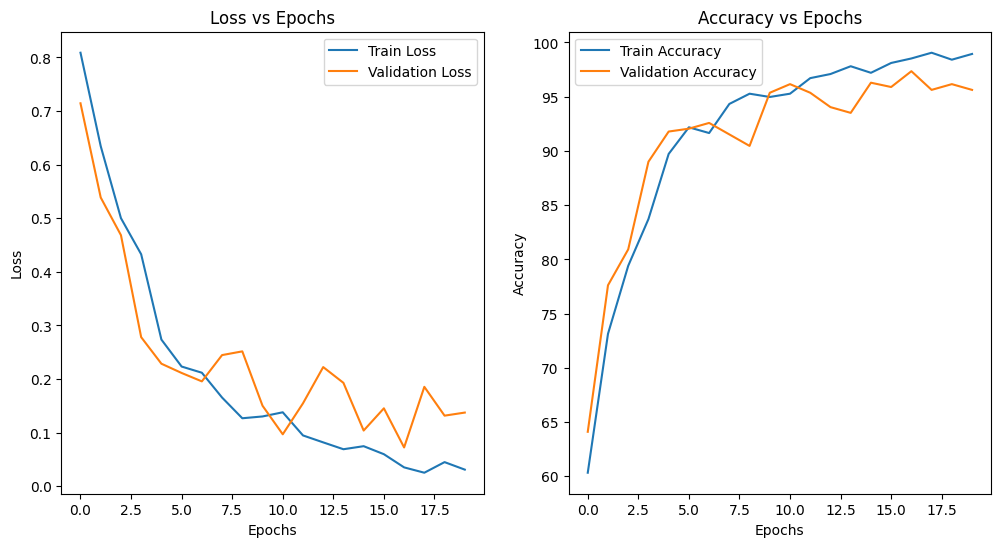

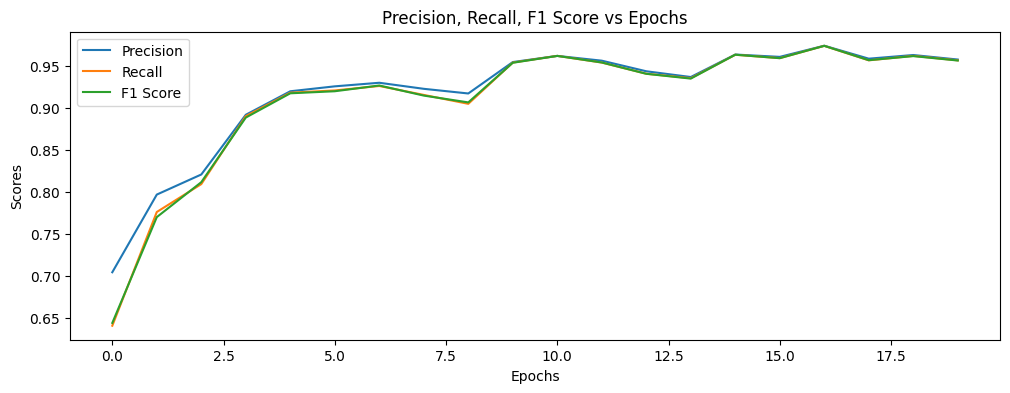

In [28]:
def plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy, precision, recall, f1):
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.show()

    # Plot Precision, Recall, F1-Score
    plt.figure(figsize=(12, 4))
    plt.plot(precision, label='Precision')
    plt.plot(recall, label='Recall')
    plt.plot(f1, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title('Precision, Recall, F1 Score vs Epochs')
    plt.legend()
    plt.show()

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy, precision_scores, recall_scores, f1_scores)



In [25]:
# Save the model's weights
torch.save(model.state_dict(), "/kaggle/working/Guava_model_weights.pth")
print("Model weights saved successfully.")


Model weights saved successfully.


In [27]:
# Load the model's weights
# Load the model's weights with the updated flag
model.load_state_dict(torch.load("/kaggle/working/Guava_model_weights.pth", weights_only=True))
model.eval()  # Set the model to evaluation mode (important for inference)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize test metrics
test_accuracy = 0
precision_scores, recall_scores, f1_scores = [], [], []
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during inference
    for inputs, labels in test_loader:
        # Move the inputs and labels to the correct device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass through the model
        outputs = model(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)
        
        # Count correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect all labels and predictions for metrics calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = (correct / total) * 100

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

# Print out metrics
print(f'Test Accuracy: {accuracy:.2f}%')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1-Score: {f1:.4f}')


Test Accuracy: 93.19%
Test Precision: 0.9495
Test Recall: 0.9481
Test F1-Score: 0.9477
